# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [1]:
# Import standard modules
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import sys
from pathlib import Path


# BASE_DIR = Path(__file__).absolute().parent.parent # Uncomment for python files
BASE_DIR = os.path.dirname(os.getcwd()) # Comment for python files
sys.path.insert(0, str(Path(BASE_DIR) / 'utils'))

import config
from scheffer_quant.treasuries import *
from scheffer_quant.utils import read_excel_default
from scheffer_quant.statistics import calc_correlations

In [2]:
# Global variables
DATA_DIR = Path(config.DATA_DIR)
DATA_DIR.mkdir(parents=True, exist_ok=True)
QUOTE_DATE = '2024-10-31'
COMPOUNDING_FREQ = 2

FILE_PATH = Path(config.DATA_DIR) / f"treasury_quotes_{QUOTE_DATE}.xlsx"

pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [3]:
# Extract data:
treasuries_df = pd.read_excel(FILE_PATH, sheet_name='selected quotes', index_col=0)
treasuries_df.head()

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208042,note,2024-10-31,2023-04-30,2025-04-30,0.4956,0,3.8750,99.7125,99.7222,99.7174,0,99.7174,0.0449
208129,note,2024-10-31,2023-10-31,2025-10-31,0.9993,0,5.0000,100.6414,100.6608,100.6511,0,100.6511,0.0433
208213,note,2024-10-31,2024-04-30,2026-04-30,1.4949,0,4.8750,100.9297,100.9609,100.9453,0,100.9453,0.0423
208302,note,2024-10-31,2024-10-31,2026-10-31,1.9986,0,4.1250,99.9336,99.9414,99.9375,0,99.9375,0.0416
207875,note,2024-10-31,2022-04-30,2027-04-30,2.4942,0,2.7500,96.7500,96.7812,96.7656,0,96.7656,0.0413


In [4]:
t_check = treasuries_df['quote date'].values[0]
if treasuries_df['quote date'].eq(t_check).all():
    t_curr_date = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_curr_date = None

print(f'Analysis based on quotes from: {pd.to_datetime(t_curr_date):%Y-%m-%d}')

Analysis based on quotes from: 2024-10-31


In [5]:
# Calculate cash flow matrix
cf = calc_treasury_cashflows(treasuries_df)
display(cf.head())

# Adjust oct-30 to oct-31
years = cf.columns.year
years = sorted(set(years))

for year in years:
    coupon_col = f"{year}-10-30"
    principal_col = f"{year}-10-31"
    if coupon_col in cf.columns and principal_col in cf.columns:
        cf[principal_col] += cf[coupon_col]
        cf.drop(columns=coupon_col, inplace=True)
    elif coupon_col in cf.columns:
        cf.rename(columns={coupon_col: principal_col}, inplace=True)

print("\nDates-adjusted cashflow map:")
display(cf)   

,2025-04-30,2025-10-30,2025-10-31,2026-04-30,2026-10-30,2026-10-31,2027-04-30,2027-10-30,2027-10-31,2028-04-30,2028-10-30,2028-10-31,2029-04-30,2029-10-30,2029-10-31,2030-04-30,2030-10-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,0.0000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,0.0000,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,0.0000,1.3750,1.3750,0.0000,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000



Dates-adjusted cashflow map:


,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000


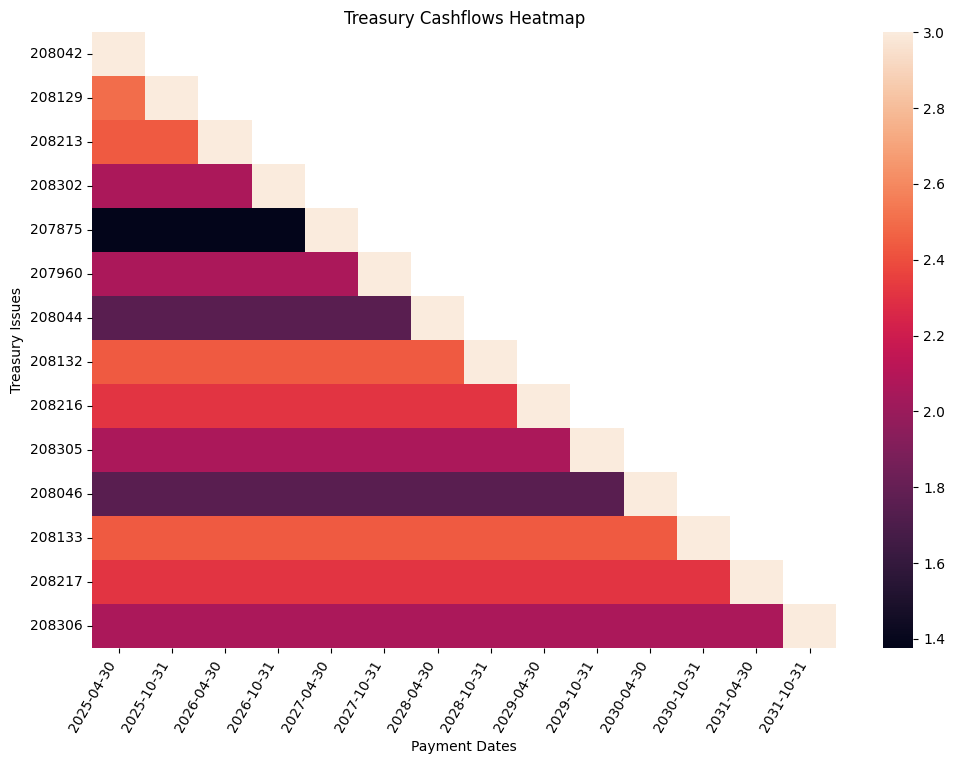

In [6]:
plot_treasury_cashflows_heatmap(cf)

### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [7]:
prices = treasuries_df['price'][cf.index]
z = np.linalg.solve(cf, prices)
z

array([0.97822049, 0.95810304, 0.93935838, 0.92106705, 0.90303423,
       0.88485588, 0.86632685, 0.84811994, 0.83111031, 0.81446174,
       0.79632959, 0.77902394, 0.76195606, 0.74636869])

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

In [8]:
treasuries_df

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208042,note,2024-10-31,2023-04-30,2025-04-30,0.4956,0,3.8750,99.7125,99.7222,99.7174,0,99.7174,0.0449
208129,note,2024-10-31,2023-10-31,2025-10-31,0.9993,0,5.0000,100.6414,100.6608,100.6511,0,100.6511,0.0433
208213,note,2024-10-31,2024-04-30,2026-04-30,1.4949,0,4.8750,100.9297,100.9609,100.9453,0,100.9453,0.0423
208302,note,2024-10-31,2024-10-31,2026-10-31,1.9986,0,4.1250,99.9336,99.9414,99.9375,0,99.9375,0.0416
207875,note,2024-10-31,2022-04-30,2027-04-30,2.4942,0,2.7500,96.7500,96.7812,96.7656,0,96.7656,0.0413
207960,note,2024-10-31,2022-10-31,2027-10-31,2.9979,0,4.1250,99.9922,100.0156,100.0039,0,100.0039,0.0413
208044,note,2024-10-31,2023-04-30,2028-04-30,3.4962,0,3.5000,97.9023,97.9414,97.9219,0,97.9219,0.0415
208132,note,2024-10-31,2023-10-31,2028-10-31,4.0000,0,4.8750,102.5859,102.6211,102.6035,0,102.6035,0.0416
208216,note,2024-10-31,2024-04-30,2029-04-30,4.4956,0,4.6250,101.8945,101.9297,101.9121,0,101.9121,0.0416


In [9]:
time_to_maturity = cf.columns - t_curr_date
time_to_maturity = np.round(time_to_maturity.days / 365, 2)

fig = px.line(
    x=time_to_maturity, 
    y=z, 
    labels={"x": "Time to Maturity", "y": "Discount Factor"}, 
    title="Discount Factors"
)
fig.update_layout(
    showlegend=False,
    yaxis=dict(
        tickformat=".4f",
        gridcolor='lightgrey',
        showgrid=True  # Ensure grid is enabled on the y-axis
    )
)
fig.show()

In [10]:
int_rates = discount_to_int_rate(discount=z, time_to_maturity=time_to_maturity, n_compound=COMPOUNDING_FREQ)

fig = px.line(
    int_rates, 
    labels={"x": "Time to Maturity", "y": "Interest Rates"}, 
    title="Interest Rates"
)
fig.update_layout(
    showlegend=False,
    yaxis=dict(
        tickformat=".4f",
        gridcolor='lightgrey',
        showgrid=True  # Ensure grid is enabled on the y-axis
    )
)
fig.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [11]:
rADJ = .005

int_rates_up = (int_rates + rADJ).to_numpy().flatten()
z_up = (int_rate_to_discount(interest_rate=int_rates_up, time_to_maturity=time_to_maturity, n_compound=COMPOUNDING_FREQ)).to_numpy()
cf_up = (cf.where(cf == 0, cf + rADJ/2*100)).to_numpy()

treasuries_df['new_price'] = np.dot(cf_up, z_up).flatten()
treasuries_df['price_diff'] = (treasuries_df['new_price'] - treasuries_df['price']) / treasuries_df['price']
treasuries_df['time_to_maturity'] = time_to_maturity
display(treasuries_df[['time_to_maturity', 'cpn rate', 'price', 'new_price', 'price_diff']])

,time_to_maturity,cpn rate,price,new_price,price_diff
KYTREASNO,,,,,
208042,0.5000,3.8750,99.7174,99.7180,0.0000
208129,1.0000,5.0000,100.6511,100.6486,-0.0000
208213,1.5000,4.8750,100.9453,100.9402,-0.0001
208302,2.0000,4.1250,99.9375,99.9369,-0.0000
207875,2.5000,2.7500,96.7656,96.7876,0.0002
207960,3.0000,4.1250,100.0039,100.0025,-0.0000
208044,3.5000,3.5000,97.9219,97.9408,0.0002
208132,4.0000,4.8750,102.6035,102.5754,-0.0003
208216,4.5000,4.6250,101.9121,101.8889,-0.0002


This is the essence of floating rate notes (FRN) pricing.

***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [12]:
treasuries_all = pd.read_excel(FILE_PATH, sheet_name='quotes', index_col=0)
t_curr_date = treasuries_all['quote date'].values[0]

cf_set = dict()

display(treasuries_all)

,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
KYTREASNO,,,,,,,,,,,,,
208246,bill,2024-10-31,2024-07-09,2024-11-05,0.0137,0.9726,0.0000,99.9478,99.9479,99.9479,0.0000,99.9479,0.0385
208222,bill,2024-10-31,2024-05-09,2024-11-07,0.0192,0.9617,0.0000,99.9224,99.9225,99.9224,0.0000,99.9224,0.0409
208247,bill,2024-10-31,2024-07-16,2024-11-12,0.0329,0.9343,0.0000,99.8575,99.8578,99.8576,0.0000,99.8576,0.0438
208223,bill,2024-10-31,2024-05-16,2024-11-14,0.0383,0.9233,0.0000,99.8326,99.8329,99.8328,0.0000,99.8328,0.0442
204083,bond,2024-10-31,1994-05-15,2024-11-15,0.0411,0.9185,7.5000,100.1140,100.1144,100.1142,3.4443,103.5585,0.0455
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208149,bond,2024-10-31,2023-11-15,2053-11-15,29.0404,0.9185,4.7500,104.2812,104.3359,104.3086,2.1814,106.4900,0.0448
208191,TIPS note,2024-10-31,2024-02-15,2054-02-15,29.2923,0.0000,2.1250,98.9651,99.1370,99.0511,0.0000,99.0511,NaN
208178,bond,2024-10-31,2024-02-15,2054-02-15,29.2923,0.4185,4.2500,96.1250,96.1719,96.1484,0.8893,97.0377,0.0449


### Extra: Bootstrap

In [13]:
# Extract data:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

treasuries_boots = filter_treasuries(treasuries_all, date_curr=t_curr_date, filter_tips=RESTRICT_TIPS, filter_yld=RESTRICT_YLD, drop_duplicate_maturities=RESTRICT_REDUNDANT)
cf_boots = filter_treasury_cashflows(calc_treasury_cashflows(treasuries_boots), filter_maturity_dates=RESTRICT_DTS_MATURING)

prices_boots = treasuries_all['dirty price'][cf_boots.index]
params_boots = estimate_rate_curve(model_name='bootstrap', cf=cf_boots, prices=prices_boots, date_current=t_curr_date)

label = 'single maturity per date, no non-maturity dates'
cf_set[label] = cf_boots

time_to_maturity = cf_boots.columns - t_curr_date
time_to_maturity = np.round(time_to_maturity.days / 365, 2)

fig = px.line(
    x=params_boots[0], 
    y=params_boots[1], 
    labels={"x": "Time to Maturity", "y": "Discount Factor"}, 
    title="Discount Curve (Bootstrapping)"
)
fig.update_layout(
    showlegend=False,
    yaxis=dict(
        tickformat=".4f",
        gridcolor='lightgrey',
        showgrid=True  # Ensure grid is enabled on the y-axis
    )
)
fig.show()

In [14]:
# Calculate cash flow matrix
cf = calc_treasury_cashflows(treasuries_all)

cf_set['all dates, all issues'] = cf
display(cf)   

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,2024-12-03,2024-12-05,2024-12-10,2024-12-12,2024-12-15,...,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208222,0,100,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208247,0,0,100,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208223,0,0,0,100,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
204083,0,0,0,0,103.7500,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208149,0,0,0,0,2.3750,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.0000,0.0000,0.0000
208191,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,1.0625,0.0000,1.0625,0.0000,1.0625,0.0000,1.0625,0.0000,1.0625,0.0000,1.0625,0.0000,101.0625,0.0000,0.0000
208178,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.1250,0.0000,0.0000


In [15]:
most_cf_dt = cf_boots.sum(axis=0).idxmax()
most_issues_dt = cf_boots.where(cf_boots == 0, 1).sum(axis=0).idxmax()

print(f"Most cashflow on {most_cf_dt}")
print(f"Most issues paying cashflow on {most_issues_dt}")

Most cashflow on 2025-02-15 00:00:00
Most issues paying cashflow on 2024-11-15 00:00:00


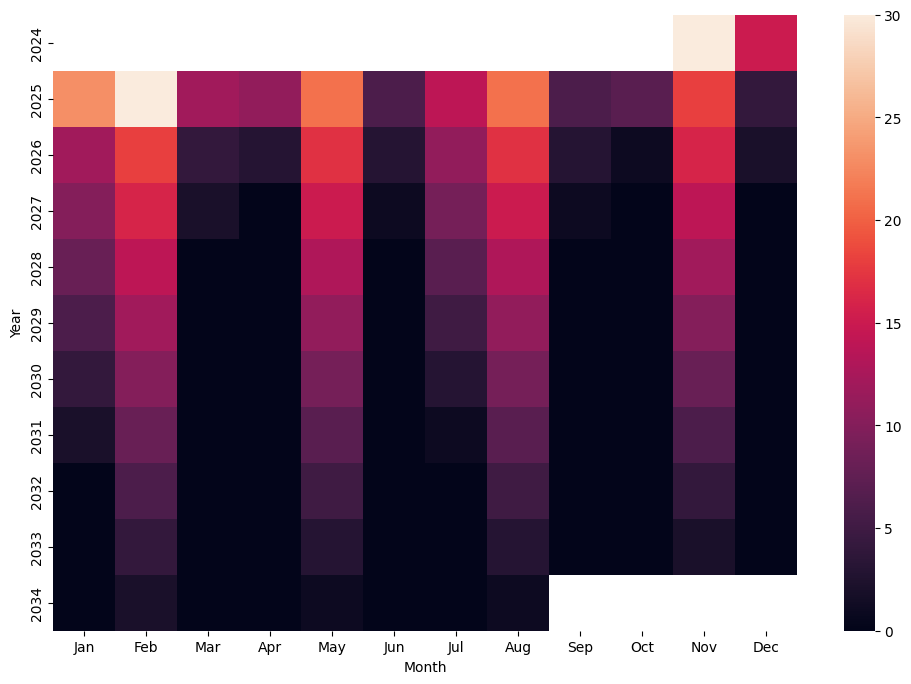

In [16]:
num_cf_per_month = cf_boots.where(cf_boots == 0, 1).sum(axis=0).resample('ME').sum()
plot_heatmap_year_month(num_cf_per_month)

### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [17]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False


label = 'no non-maturity dates'

treasuries_OLS = filter_treasuries(treasuries_all, date_curr=t_curr_date, filter_tips=RESTRICT_TIPS, filter_yld=RESTRICT_YLD, drop_duplicate_maturities=RESTRICT_REDUNDANT)
cf_ols = filter_treasury_cashflows(calc_treasury_cashflows(treasuries_OLS), filter_maturity_dates=RESTRICT_DTS_MATURING)

cf_set[label] = cf_ols

display(cf_ols)


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,2024-12-03,2024-12-05,2024-12-10,2024-12-12,2024-12-15,...,2031-05-15,2031-07-31,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208222,0,100,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208247,0,0,100,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208223,0,0,0,100,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
204083,0,0,0,0,103.7500,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208105,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375,0.0000,0.0000,0.0000,0.0000
208147,0,0,0,0,2.2500,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.2500,0.0000,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.0000
208177,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,102.0000,0.0000,0.0000


In [18]:
# Perform OLS
prices_filtered = treasuries_OLS['dirty price'][cf_ols.index]
params_OLS = estimate_rate_curve(model_name='OLS', cf=cf_ols, prices=prices_filtered, date_current=t_curr_date)
maturities_ols = params_OLS

fig = px.line(
    x=params_OLS[0], 
    y=params_OLS[1],
    labels={"x": "Time to Maturity", "y": "Interest Rates"}, 
    title="Discount Curve: OLS",
    markers=True
)
fig.update_layout(
    showlegend=False,
    yaxis=dict(
        tickformat=".4f",
        gridcolor='lightgrey',
        showgrid=True,  # Ensure grid is enabled on the y-axis
        dtick=0.05  # Set y-axis tickers every 0.05
    )
)
fig.show()

In [19]:
inc = .5

maturity_grid = np.arange(inc,np.array(maturities_ols).max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boots,maturity_grid)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid)

fig = px.line(
    curves_ols, 
    title="Discount Curves: OLS vs Bootstrapping",
    markers=True
)
fig.update_layout(
    showlegend=True,
    xaxis_title="Time to Maturity",
    yaxis_title="Interest Rates",
    yaxis=dict(
        tickformat=".4f",
        gridcolor='lightgrey',
        showgrid=True  # Ensure grid is enabled on the y-axis
    )
)
fig.show()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [20]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

label = 'all maturities'
treasuries_NS = filter_treasuries(treasuries_all, date_curr=t_curr_date, filter_tips=RESTRICT_TIPS, filter_yld=RESTRICT_YLD, drop_duplicate_maturities=RESTRICT_REDUNDANT)
cf_NS = filter_treasury_cashflows(calc_treasury_cashflows(treasuries_NS), filter_maturity_dates=RESTRICT_DTS_MATURING)

cf_set[label] = cf_NS
display(cf_NS)

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,2024-12-03,2024-12-05,2024-12-10,2024-12-12,2024-12-15,...,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208246,100,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208222,0,100,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208247,0,0,100,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208223,0,0,0,100,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
204083,0,0,0,0,103.7500,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208107,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.0625,0.0000,2.0625,0.0000,2.0625,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.0000,0.0000,0.0000
208149,0,0,0,0,2.3750,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.0000,0.0000,0.0000
208178,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.1250,0.0000,0.0000


In [21]:
prices_NS = treasuries_NS['dirty price'].loc[cf_NS.index]

AVG_LEVEL = .045
AVG_SLOPE = -.005
FIRST_HUMP = .01
FIRST_DECAY = 2
SECOND_HUMP = -.01
SECOND_DECAY = 2


x0 = np.array([AVG_LEVEL, AVG_SLOPE, FIRST_HUMP, FIRST_DECAY])
params_NS = estimate_rate_curve(model_name='nelson_siegel', cf=cf_NS, prices=prices_NS, date_current=t_curr_date, x0=x0)

x0_ext = np.concatenate((params_NS,(SECOND_HUMP, SECOND_DECAY)))
params_NSE = estimate_rate_curve(model_name='nelson_siegel_extended', cf=cf_NS, prices=prices_NS, date_current=t_curr_date, x0=x0_ext)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
tab_params_ns

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.0479,-0.0022,-0.0204,2.1269,None,None
Nelson-Siegel Extended,0.0479,-0.0039,-0.8860,1.6139,0.8688,1.5989


_Note: graphs created using ChatGPT: "Combine int_rates_ols and ns_curve_df into one graph using plotly express". Assume both dataframes have different  different number of rows, so concating will lead to many nan and merging would remove some rows"_

In [36]:
maturity_list = get_maturity_delta(t_maturity=cf_NS.columns,date_current=t_curr_date)
maturity_grid = np.arange(0.25, maturity_list.max()+.5, 0.25)
curves_ns_df = pd.DataFrame(index = maturity_grid)
curves_ns_df['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves_ns_df['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

# Create an empty figure
fig = go.Figure()

# Add the first set of data (curves_ols)
for col in curves_ols.columns:
    fig.add_trace(go.Scatter(
        x=curves_ols.index, 
        y=curves_ols[col], 
        mode='lines+markers', 
        name=col  # Add legend name from series_names
    ))

# Add the second set of data (curves_ns_df)
for col in curves_ns_df.columns:
    fig.add_trace(go.Scatter(
        x=curves_ns_df.index, 
        y=curves_ns_df[col], 
        mode='lines+markers', 
        name=col  # Add legend name from series_names
    ))

# Update layout to customize axis labels and grid style
fig.update_layout(
    title="Spot Curve and Discount Curve Estimates",
    xaxis_title="Time to Maturity",
    yaxis_title="Interest Rates",
    legend_title="Curve Types",
    yaxis=dict(
        tickformat=".4f",
        gridcolor='lightgrey',
        showgrid=True  # Ensure grid is enabled on the y-axis
    )
)

# Show the figure
fig.show()


#### Extra: Compare to raw YTMs

In [37]:
raw_ytm_df = treasuries_all.set_index('ttm')['ytm']
raw_ytm_df = raw_ytm_df.sort_index(ascending=True)

# Add new data to the existing figure

fig.add_trace(go.Scatter(
    x=raw_ytm_df.index,
    y=raw_ytm_df.values,
    mode='markers',
    marker=dict(color='black', symbol='x', size=5),
    name='quoted ytm'
))

# Show the updated figure
fig.show()


***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [45]:
FILE_PATH_YLD_CURVE = Path(config.DATA_DIR) / "yields.xlsx"
yields = read_excel_default(excel_name=FILE_PATH_YLD_CURVE, sheet_name='yields',index_col=0)

yields

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.9359,3.3607,3.6237,3.7687,3.8188,3.8142,3.8152
1961-06-15,2.9329,3.3765,3.6717,3.8042,3.8630,3.8282,3.8263
1961-06-16,2.9299,3.3757,3.6854,3.8042,3.8633,3.8329,3.8300
1961-06-19,2.9209,3.3900,3.7130,3.8246,3.8862,3.8424,3.8375
1961-06-20,2.9524,3.3558,3.6854,3.8093,3.8865,3.8565,3.8450
...,...,...,...,...,...,...,...
2024-05-24,5.1516,4.8768,4.4779,4.4221,4.4133,4.6410,4.5138
2024-05-28,5.1496,4.9211,4.5507,4.5123,4.4989,4.7375,4.6130
2024-05-29,5.2314,4.9334,4.6039,4.5667,4.5616,4.8026,4.6795


In [47]:
yields.index.name = 'date'
shapes = pd.DataFrame(yields.mean(axis=1), columns=['level'])
shapes['slope'] = yields['30'] - yields['1']
shapes['curvature'] = -yields['1'] + 2* yields['10'] - yields['30']

DATETHRESH = '2010-01-01'
shapesT = shapes[shapes.index > DATETHRESH]
shapes.describe()

,level,slope,curvature
count,15723.0000,15723.0000,15723.0000
mean,5.4752,1.1098,0.6718
std,2.9147,1.4803,0.9719
min,0.4876,-3.4903,-5.4268
25%,3.4478,-0.0128,0.0966
50%,5.1937,1.0110,0.6238
75%,7.1670,2.1240,1.3359
max,15.2596,4.3583,3.2838


In [88]:
shapes.corr()

,level,slope,curvature
level,1.0000,-0.3760,-0.1693
slope,-0.3760,1.0000,0.6477
curvature,-0.1693,0.6477,1.0000


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [68]:
pca = PCA(svd_solver='full')
pca.fit(yields)
pca_loadings = pd.DataFrame(
    pca.components_,
    columns=yields.columns,
    index=['PC 1 (Level)', 'PC 2 (Slope)', 'PC 3 (Curvature)'] + [f'PC {i+1}' for i in range(3, pca.n_components_)]
)
display(pca_loadings)

,1,2,5,7,10,20,30
PC 1 (Level),0.4115,0.4111,0.3928,0.3784,0.3634,0.3441,0.3374
PC 2 (Slope),0.5910,0.3993,0.0468,-0.0874,-0.2027,-0.4389,-0.4978
PC 3 (Curvature),0.4555,0.0073,-0.3924,-0.4484,-0.3635,0.3630,0.4165
PC 4,0.3578,-0.3857,-0.3729,-0.1046,0.7405,-0.0692,-0.1419
PC 5,-0.0200,-0.0148,0.0161,-0.0119,-0.0500,0.7430,-0.6667
PC 6,0.3403,-0.5711,-0.0136,0.6432,-0.3794,-0.0165,0.0007
PC 7,0.1724,-0.4432,0.7416,-0.4726,-0.0056,-0.0137,0.0163


In [77]:
# Ensure that the slope factor follows standard financial interpretation
# If the 10-year maturity loading for the slope component is negative, invert all slope weights
if pca_loadings.loc['PC 2 (Slope)', '10'] < 0:
    pca_loadings.loc['PC 2 (Slope)'] *= -1  # Flip the sign to maintain an intuitive upward slope

# Ensure that the curvature factor follows standard financial interpretation
# If the 10-year maturity loading for the curvature component is negative, invert all curvature weights
if pca_loadings.loc['PC 3 (Curvature)', '10'] < 0:
    pca_loadings.loc['PC 3 (Curvature)'] *= -1  # Flip the sign to maintain an intuitive hump-like curvature

# Plot the first three principal components (Level, Slope, Curvature) across maturities

fig = px.line(pca_loadings.T.iloc[:, 0:3], labels={"value": "Loading", "index": "Maturity"}, title="Principal Component Loadings")
fig.update_layout(
    legend_title_text='Principal Components',
    yaxis=dict(
        tickformat=".2f",
        zeroline=True,
        zerolinecolor='darkgray', 
        zerolinewidth=1,
        gridcolor='lightgrey',
        showgrid=True  # Ensure grid is enabled on the y-axis
    )
)
fig.show()

In [78]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

pc_var_ratio = pd.DataFrame({
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance Ratio': cumulative_variance
}, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

display(pc_var_ratio.style.format('{:.2%}'.format))

# Cumulative explained variance
fig = px.line(
    x=range(1, len(cumulative_variance) + 1), 
    y=cumulative_variance, 
    labels={"x": "Number of Principal Components", "y": "Cumulative Explained Variance"},
    title="PCA Explained Variance"
)
fig.update_traces(mode='lines+markers')
fig.update_layout(
    xaxis=dict(tickmode='linear'),
    yaxis=dict(gridcolor='lightgrey', showgrid=True)
)
fig.show()


,Explained Variance Ratio,Cumulative Variance Ratio
PC1,97.07%,97.07%
PC2,2.53%,99.60%
PC3,0.29%,99.89%
PC4,0.05%,99.94%
PC5,0.04%,99.98%
PC6,0.02%,99.99%
PC7,0.01%,100.00%


In [80]:
pca_loadings

,1,2,5,7,10,20,30
PC 1 (Level),0.4115,0.4111,0.3928,0.3784,0.3634,0.3441,0.3374
PC 2 (Slope),-0.5910,-0.3993,-0.0468,0.0874,0.2027,0.4389,0.4978
PC 3 (Curvature),-0.4555,-0.0073,0.3924,0.4484,0.3635,-0.3630,-0.4165
PC 4,0.3578,-0.3857,-0.3729,-0.1046,0.7405,-0.0692,-0.1419
PC 5,-0.0200,-0.0148,0.0161,-0.0119,-0.0500,0.7430,-0.6667
PC 6,0.3403,-0.5711,-0.0136,0.6432,-0.3794,-0.0165,0.0007
PC 7,0.1724,-0.4432,0.7416,-0.4726,-0.0056,-0.0137,0.0163


In [82]:
pca_factors = yields @ pca_loadings.T
display(pca_factors.iloc[0:5,0:2])

,PC 1 (Level),PC 2 (Slope)
date,,
1961-06-14,9.4261,1.4298
1961-06-15,9.4883,1.4467
1961-06-16,9.4951,1.4522
1961-06-19,9.5299,1.4648
1961-06-20,9.5197,1.4697


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [87]:
pd.concat([shapes, pca_factors.iloc[:,0:3]], axis=1, keys=['shapes', 'pca']).corr().loc['shapes', 'pca'].style.format('{:.1%}')

,PC 1 (Level),PC 2 (Slope),PC 3 (Curvature)
level,100.0%,1.2%,-0.1%
slope,-38.7%,91.8%,1.1%
curvature,-17.6%,64.0%,70.1%
